In [ ]:
# 1. 코드 연동, 작업공간 변경
from google.colab import drive
drive.mount('/content/drive') # 연동하는 코드

# 2. 아이콘 연동, 작업공간 변경
%cd /content/drive/MyDrive/Colab Notebooks/dx

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/dx


# Cluster 별 Action 분석
**자신이 맡은 클러스터만 지정해주면 됨**

* LDA 활용
* Action Map


In [1]:
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('./3rd_clustering_0512.csv', encoding='utf-8')

print(df.shape)
df.head(3)

(52891, 10)


,source,search_words,url,title,contents,tagged_contents,vector,umap_kmeans_cluster,2nd_cluster,3rd_cluster
0,블로그,아기+잠깨,https://blog.naver.com/srhymin/223091161466,NaN,저희 아기는 신생아때부터 청각과 촉각이 예민해 잠도 깊게 못 잘 뿐더러 잠투정이 정...,"['저희', '아기', '신생아', '때', '청각', '촉각', '잠도', '못'...",[ 0.18305127 -1.2801502 -0.44998685 0.799018...,4,2,4
1,블로그,아기+잠깨,https://blog.naver.com/sukm83/223091879514,NaN,정신없는 주방한켠 뒤죽박죽 알 수 없는 용기에 양념과 소스가 담겨져 있기에 주방이 ...,"['정신', '방한', '뒤죽박죽', '알', '수', '용기', '양념', '소스...",[ 3.5914354e+00 -2.2061694e+00 1.5965343e+00 ...,1,3,1
2,블로그,아기+잠깨,https://blog.naver.com/dldptmf5134/223096875782,NaN,안녕하세요 지유맘입니다! 오늘은 지유가 이유식과 유아식 그 중간즈음 토핑식을 할 때...,"['지유', '맘', '오늘', '지유', '이유식', '유아식', '그', '중간...",[ 3.4138811e-01 -5.3281033e-01 -1.3500248e+00 ...,1,3,2


In [3]:
df['3rd_cluster'].value_counts().sort_index()

3rd_cluster
0      983
1     6272
2     4681
3    17219
4    17011
5     6725
Name: count, dtype: int64

## LDA 를 위한 전처리

#### gensim 설치
Colab 노트북 상단에 반드시 한 번만 실행
!pip install --quiet gensim==4.3.1

!pip uninstall gensim
!pip install gensim==3.4.0

1) 기존 scipy 제거
!pip uninstall -y scipy

2) gensim이 필요로 하는 scipy 함수가 남아 있는 1.12.0 설치
!pip install scipy==1.12.0

In [ ]:
!pip install gensim==3.4.0

In [ ]:
!pip install scipy==1.12.0

In [3]:
import collections.abc, collections
collections.Mapping = collections.abc.Mapping

In [4]:
import gensim
from gensim import corpora, models
from gensim.corpora import Dictionary

my_cluster = 5
df_cluster = df[df['3rd_cluster'] == my_cluster]
df_cluster.head(2)

,source,search_words,url,title,contents,tagged_contents,vector,umap_kmeans_cluster,2nd_cluster,3rd_cluster
18,블로그,아기+잠깨,https://blog.naver.com/kittyhwang/223091454956,NaN,이젠 슬슬 여름 맞이 에어컨 청소도 하고 이불도 얇고 시원한걸로 바꾸고 냉매트 준비...,"['젠', '슬슬', '여름', '맞이', '에어컨', '청소', '이불', '냉'...",[ 1.8605886 -2.3287573 0.3663352 0.120231...,5,1,5
26,블로그,아기+잠깨,https://blog.naver.com/junyeong0212/223090791914,NaN,아기가 정말 감사하게도 50일 경부터 통잠을 잤다. 밤에는 입면도 스스로 잘했다. ...,"['아기', '정말', '경', '통잠', '밤', '입면', '스스로', '스와들...",[ 1.96671498e+00 -1.77841878e+00 -6.00637555e-...,5,5,5


In [5]:
import ast

In [6]:
# 문자열이 들어있는 경우만 literal_eval
def to_list(x):
    return ast.literal_eval(x) if isinstance(x, str) else x

In [7]:
df_cluster['tagged_contents'] = df_cluster['tagged_contents'].apply(to_list)

### 전체 단어의 사전 만들고 각 문서에 매칭하기

* 단일워드 또는 바이그램 또는 트라이그램 선택하기

##### 이번에는 사용 X 단일 워드 코드 #####

all_documents = list(df_cluster['tagged_contents'])
dictionary = Dictionary(all_documents)

##### 바이그램 코드 #####

In [8]:
from nltk import bigrams, trigrams

In [9]:
# bigrams 만들기
all_documents = []

for i in df_cluster['tagged_contents'] :
    bi_r = list(bigrams(i))
    bi_r = [' '.join(j) for j in bi_r]
    all_documents.append(bi_r)

dictionary = Dictionary(all_documents)

In [10]:
# 딕셔너리랑 매칭된 단어 빈도 수
corpus = []

for doc in all_documents :
    corpus.append(dictionary.doc2bow(doc))

## LDA 모델 만들기

### LDA 토픽개수 선정하기

* coherence & perplexcity

In [11]:
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

> Perplexity 그래프 만들기

In [12]:
Perplexity_values = []

for i in tqdm(range(2, 14)) :
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = i, id2word = dictionary,
                                               passes = 10,
                                               iterations = 50)
    p_v = ldamodel.log_perplexity(corpus)
    Perplexity_values.append(p_v)

  0%|          | 0/12 [00:00<?, ?it/s]

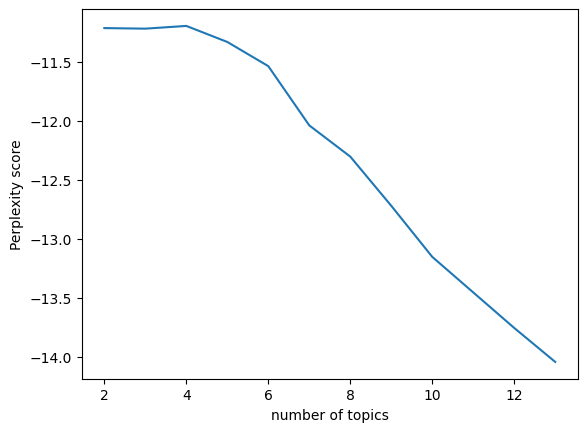

In [13]:
x = range(2, 14)
plt.plot(x, Perplexity_values)
plt.xlabel('number of topics')
plt.ylabel('Perplexity score')
plt.show()

> Cohearence 그래프 만들기

In [14]:
Coherence_values = []

for i in tqdm(range(2, 14)) :
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = i, id2word = dictionary,
                                               passes = 10,
                                               iterations = 100)
    co_model = CoherenceModel(model = ldamodel, texts = all_documents, dictionary = dictionary, topn = 10)
    c_v = co_model.get_coherence()
    Coherence_values.append(c_v)

  0%|          | 0/12 [00:00<?, ?it/s]

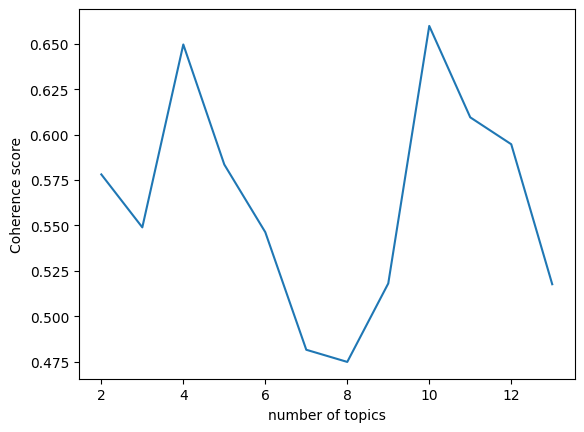

In [15]:
x = range(2, 14)
plt.plot(x, Coherence_values)
plt.xlabel('number of topics')
plt.ylabel('Coherence score')
plt.show()

### 선정한 토픽 개수로 Action 넘버 매칭

In [16]:
number_topic = 10 # 선정된 최적의 토픽 수
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = number_topic, id2word = dictionary,
                                           passes = 10,
                                           iterations = 100)

In [17]:
action_align = []

for doc in ldamodel.get_document_topics(corpus) :
    topic = []
    value = []
    for i in doc :
        topic.append(i[0])
        value.append(i[1])

    action_align.append(topic[np.argmax(value)])


df_cluster['action_cluster'] = action_align
df_cluster.head(2)

,source,search_words,url,title,contents,tagged_contents,vector,umap_kmeans_cluster,2nd_cluster,3rd_cluster,action_cluster
18,블로그,아기+잠깨,https://blog.naver.com/kittyhwang/223091454956,NaN,이젠 슬슬 여름 맞이 에어컨 청소도 하고 이불도 얇고 시원한걸로 바꾸고 냉매트 준비...,"[젠, 슬슬, 여름, 맞이, 에어컨, 청소, 이불, 냉, 매트, 준비, 시기, 잠,...",[ 1.8605886 -2.3287573 0.3663352 0.120231...,5,1,5,5
26,블로그,아기+잠깨,https://blog.naver.com/junyeong0212/223090791914,NaN,아기가 정말 감사하게도 50일 경부터 통잠을 잤다. 밤에는 입면도 스스로 잘했다. ...,"[아기, 정말, 경, 통잠, 밤, 입면, 스스로, 스와들업, 침대, 눕힌, 후, 인...",[ 1.96671498e+00 -1.77841878e+00 -6.00637555e-...,5,5,5,7


## LDA 시각화하기

* LDAvis

In [ ]:
!pip install pyLDAvis

In [18]:
import pyLDAvis.gensim as gensimvis
import pyLDAvis

In [19]:
data_vis = gensimvis.prepare(ldamodel, corpus, dictionary)
# 저장하기
pyLDAvis.save_html(data_vis, f'./Actor{my_cluster}_LDAvis.html')
pyLDAvis.display(data_vis)

In [20]:
display(ldamodel.print_topics(num_words = 5))

[(0,
  '0.022*"머 쿨쿨" + 0.019*"아기 베개" + 0.016*"가드 키즈" + 0.015*"모로 반사" + 0.012*"키즈 아기"'),
 (1,
  '0.020*"팸 퍼스" + 0.008*"아기 블랭킷" + 0.008*"에어 차차" + 0.008*"통잠 팬티" + 0.007*"뱀부 코튼"'),
 (2,
  '0.006*"헬로 이주" + 0.005*"엘림 코리아" + 0.002*"낮잠 베개" + 0.002*"소닉 슬립" + 0.002*"핸드 메이드"'),
 (3,
  '0.011*"라스 베개" + 0.010*"쁘띠 다나" + 0.008*"슬립 스파" + 0.003*"꿀잠 토끼" + 0.002*"쿨 리베"'),
 (4,
  '0.066*"낮잠 이불" + 0.017*"어린이집 낮잠" + 0.010*"이불 세트" + 0.005*"사용 수" + 0.005*"아기 낮잠"'),
 (5,
  '0.026*"쿨 매트" + 0.008*"아기 쿨" + 0.007*"여름 이불" + 0.006*"밀로 앤" + 0.006*"앤 개비"'),
 (6,
  '0.010*"마 롤로" + 0.007*"방수 패드" + 0.007*"허그 곰" + 0.003*"아기 방수" + 0.003*"쉬즈 홈"'),
 (7,
  '0.002*"아가 앤" + 0.001*"콤마 낮잠" + 0.001*"복 동이" + 0.001*"메르 베" + 0.001*"메리 봉봉"'),
 (8,
  '0.044*"도 노도" + 0.042*"노도 노" + 0.016*"노 낮잠" + 0.009*"낮잠 이불" + 0.005*"이불 도"'),
 (9,
  '0.011*"아리 베베" + 0.007*"유 트러스" + 0.004*"차렵 이불" + 0.002*"인견 이불" + 0.002*"아기 인견"')]

In [21]:
### 그룹 순서 매핑 해주기 ###

action_cluster = []
for i in df_cluster['action_cluster'] :
    if i == 4:
        n = 1
    elif i == 0:
        n = 2
    elif i == 5:
        n = 3
    elif i == 1:
        n = 4
    elif i == 8:
        n = 5
    elif i == 9:
        n = 6
    elif i == 3:
        n = 7
    elif i == 6:
        n = 8
    elif i == 2:
        n = 9
    else:
        n = 10
    action_cluster.append(n)

df_cluster['action_cluster'] = action_cluster

In [22]:
df_cluster['action_cluster'].value_counts()

action_cluster
1     4613
2      796
3      545
4      282
5      147
6      121
8       69
9       60
7       55
10      37
Name: count, dtype: int64

### 피클로 저장하기

In [24]:
import pickle

In [25]:
with open(f'./Actor{my_cluster}_action.pkl', 'wb') as f:
    pickle.dump(df_cluster, f)